### Домашнее задание "Модели ARIMA"

Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import matplotlib.pyplot as plt
%matplotlib inline

Вспомогательные функции

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Для работы возьму ряд со значениями индекса Доу-Джонса. Он кажется наиболее интересным, т.к. не является стационарным, но при этом временные компоненты не являются явными и однозначными: нет единого тренда, нет какой-то конкретной сезонности

In [4]:
ts = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")['Close']

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


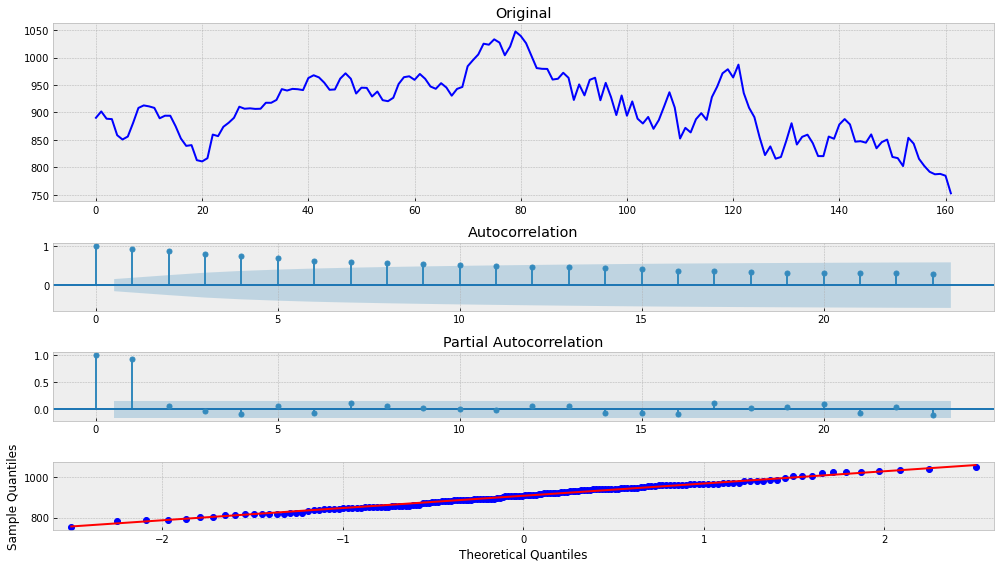

In [6]:
tsplot(ts)

Подберем параметры для модели ARIMA

In [8]:
def get_best_model(ts):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(ts, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue


    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

In [11]:
b_model = get_best_model(ts)

aic: 1416.27670 | order: (2, 2, 3)


Найденные оптимальные значения i, d и j не являются максимальными из рассматриваемых, значит искать их дальше среди значений >=5 не нужно 

Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408173e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


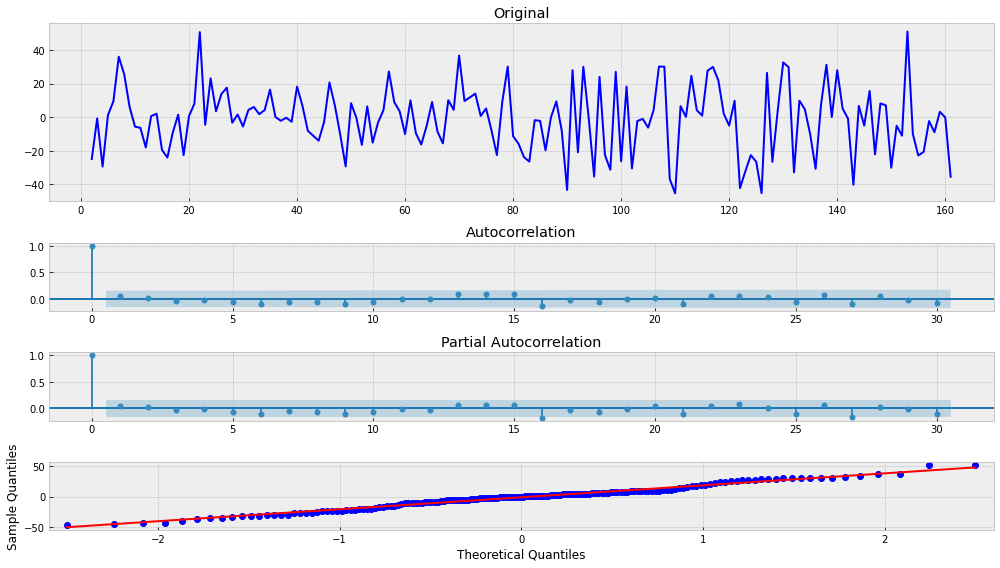

In [12]:
tsplot(b_model.resid, lags=30)

Нельзя сказать, что распределение остатков выглядит как идеальный белый шум, однако судя по qq-графику довольно близко к нормальному 

Посмотрим на предсказание дальнейшего поведения ряда нашей моделью

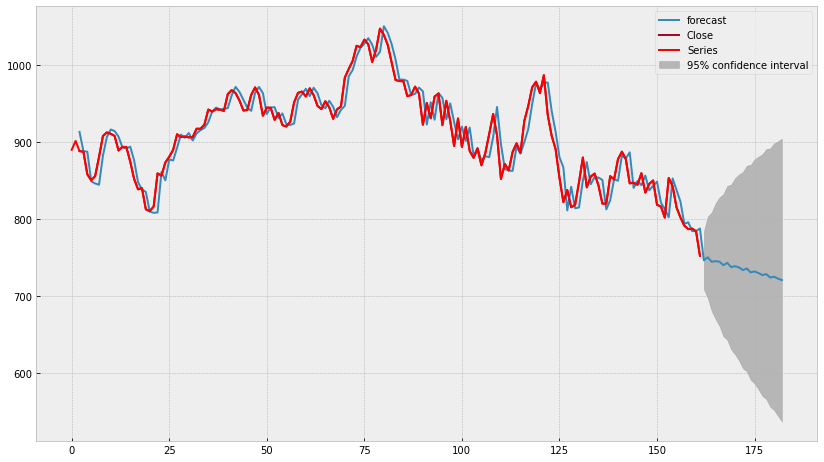

In [25]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    b_model.plot_predict(2, len(ts)+20, ax=ax)
    plt.plot(ts, color='red', label='Series')
    plt.legend()
    plt.show()

Предсказанные значения колеблются около тренда с небольшой амплитудой, что нехарактерно для предыдущего поведения ряда, где мы видим более заметные скачки. Но сам тред на понижение скорее всего пойман верно

#### Прогнозирование методами ML

Подготовим данные

In [13]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15, col_name='Count'):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[col_name].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
#     data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([col_name], axis=1)
    y_train = data.loc[:test_index][col_name]
    X_test = data.loc[test_index:].drop([col_name], axis=1)
    y_test = data.loc[test_index:][col_name]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepareData(ts, lag_start=1, lag_end=20, test_size=0.3, col_name='Close')

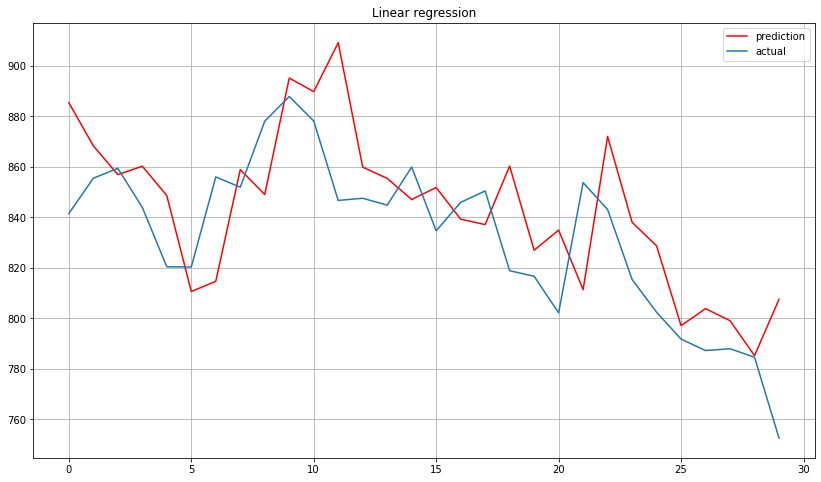

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

Обычная линейная регрессия предсказала значения не слишком хорошо.
Попробую использовать какой-нибудь другой регрессор с различными параметрами в поисках лучшего результата

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [20]:
parameters = {'n_estimators':[20, 50, 80, 100, 120], 
              'max_depth':np.arange(1,11), 
              'min_samples_split':np.arange(2,10), 
              'min_samples_leaf':np.arange(1,5)}

In [21]:
tree_grid = GridSearchCV(RandomForestRegressor(), parameters, cv = 5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [20, 50, 80, 100, 120]})

In [22]:
tree_grid.best_estimator_

RandomForestRegressor(max_depth=4, min_samples_split=3, n_estimators=20)

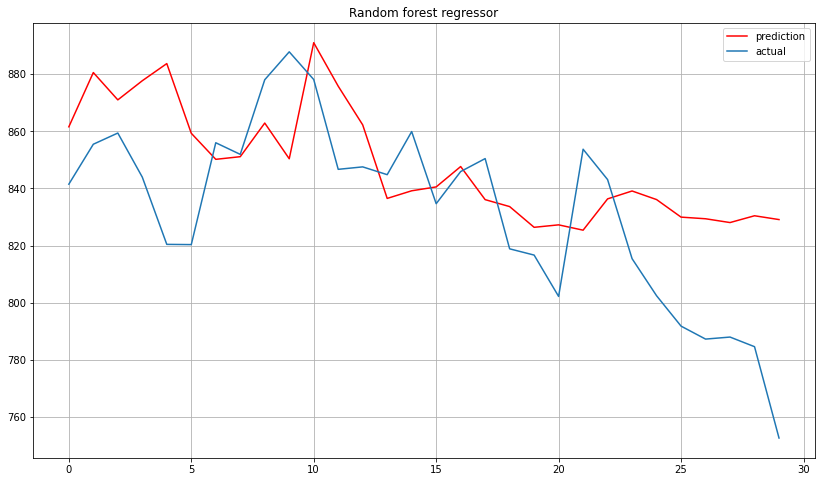

In [23]:
best_tree = tree_grid.best_estimator_
prediction = best_tree.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Random forest regressor")
plt.grid(True)

И случайному лесу не удалось как-то убедительно изобразить исходный ряд. Так что предсказывать с его помощью будущие значения, о которых мы ничего не знаем, кажется не самой целесообразной идеей.  
Вероятно для этого ряда моделирование с помощью ML не особенно подходит